In [1]:
# Generate NCI reports for given projects
#import os
import sys

# Insert your local paths here
sys.path.append(f'/g/data/gb02/public/code/nci_resource_tools')
sys.path.append(f'/g/data/gb02/public/code/nci-tools/src/ncitools')

In [2]:
import pandas as pd
import re
import io
import subprocess 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown
import datetime as dt

from nci_account import nci_account
from nci_resource_tools.read_project import retrieve_project_data, create_storage_df
from nci_resource_tools.check_allocation import check_allocation
from nci_resource_tools.check_storage import convert_size_to_bytes, find_largest_users
from config import *

# Usage

In [3]:
SU_df_dict, grant_dict, storage_dict = retrieve_project_data()

## Figures {.tabset}

### SU usage

#### Column {width=20%}

In [4]:
csv_table="""project,user,allocation
gb02, gs5098, 1040
gb02, mjl561, 300 
gb02, dh3280,  30     
gb02, pag548, 1210
gb02, sg7549, 300
fy29, mjl561, 300
fy29, sho561, 200
if69, gs5098, 300
if69, mb0427, 10
ng72, lk5320, 10
ng72, gs5098, 240
 """

In [5]:
allocation_df=pd.read_csv(io.StringIO(csv_table),skipinitialspace=True)
Index=pd.MultiIndex.from_frame(allocation_df[['project','user']])
allocation_df.set_index(Index,inplace=True)
allocation_df = allocation_df['allocation'].to_frame()

In [6]:
allocation_df

allocation
project user              
gb02    gs5098        1040
        mjl561         300
        dh3280          30
        pag548        1210
        sg7549         300
fy29    mjl561         300
        sho561         200
if69    gs5098         300
        mb0427          10
ng72    lk5320          10
        gs5098         240

In [7]:
alloc_df_dict = check_allocation(grant_dict,
                                 SU_df_dict,
                                 allocation_df)

CRITICAL : gs5098 has consumed 142.61% of their if69 SU allocation
CRITICAL : gs5098 has consumed 310.24% of their ng72 SU allocation


#### Column {width=20%}

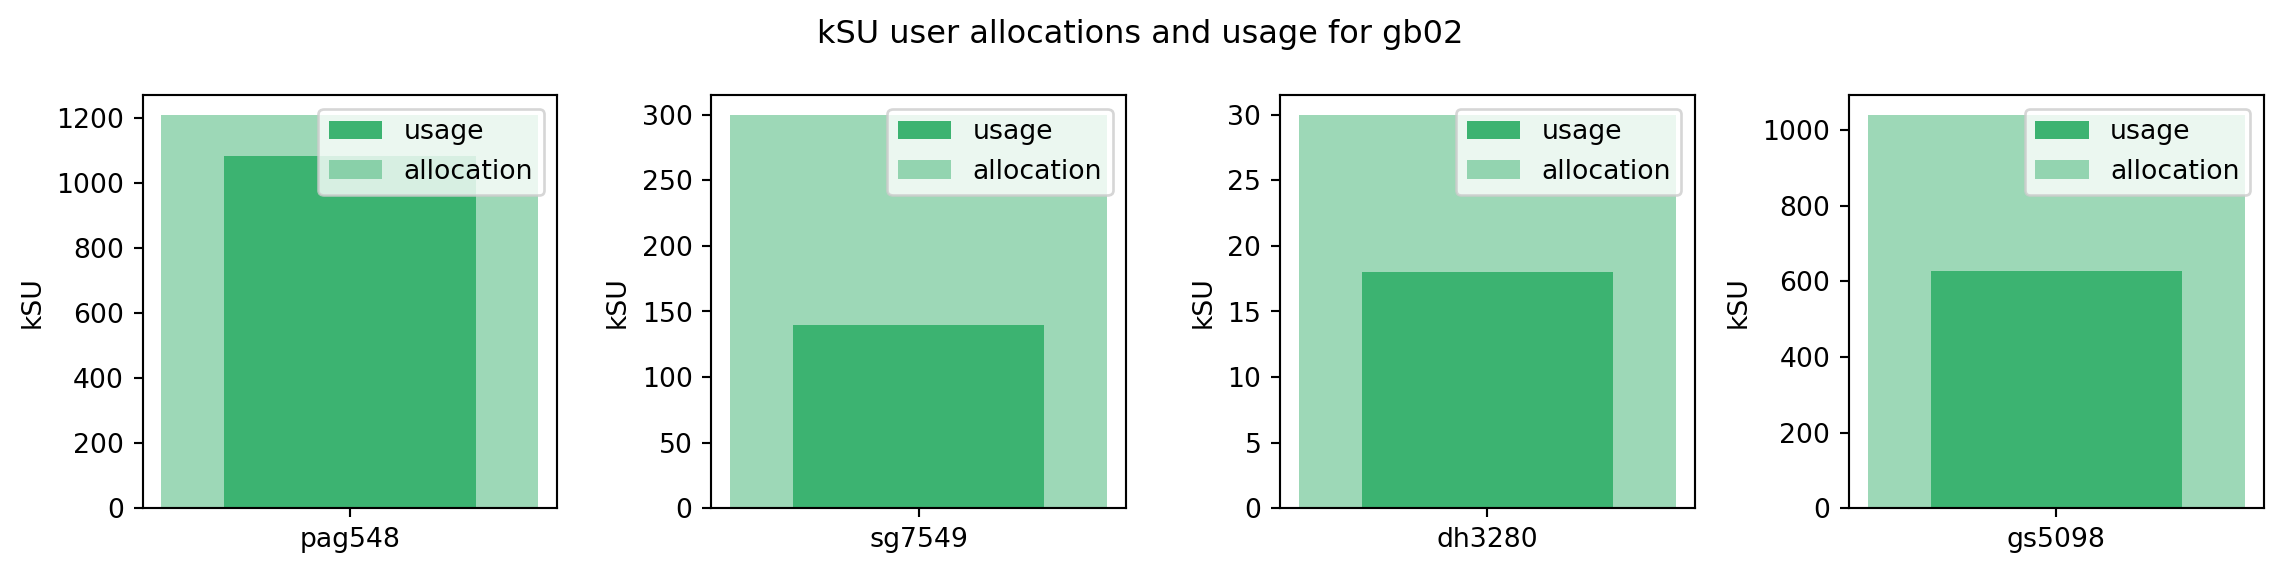

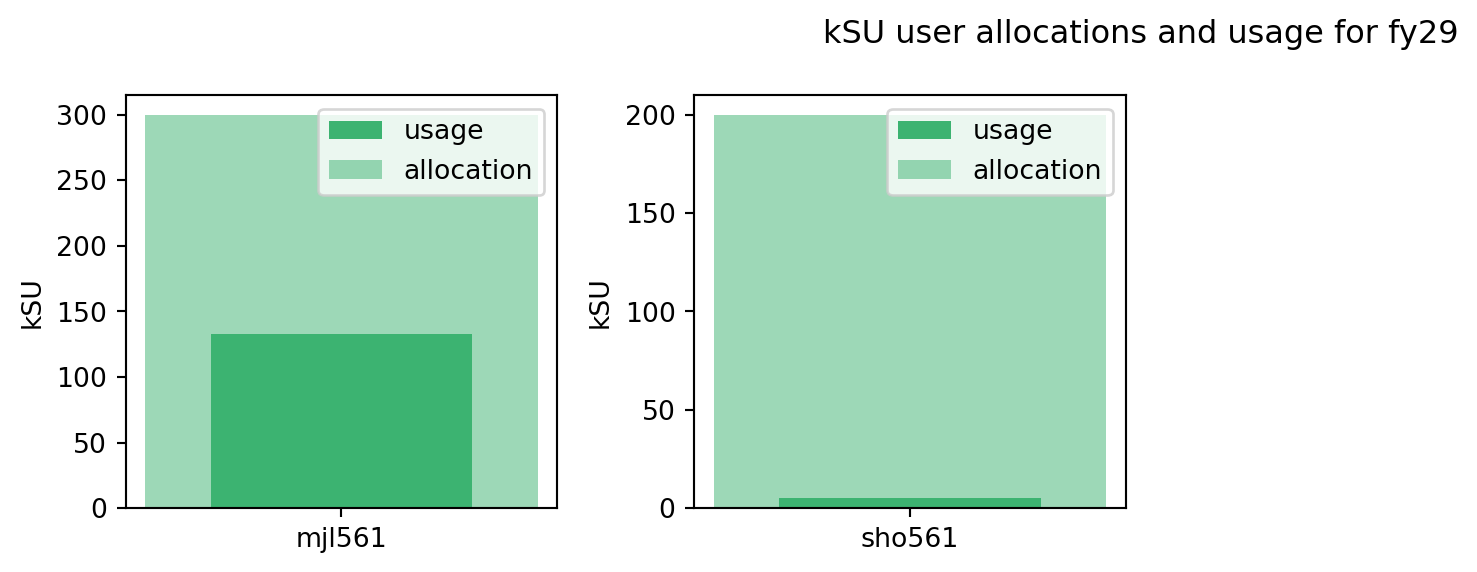

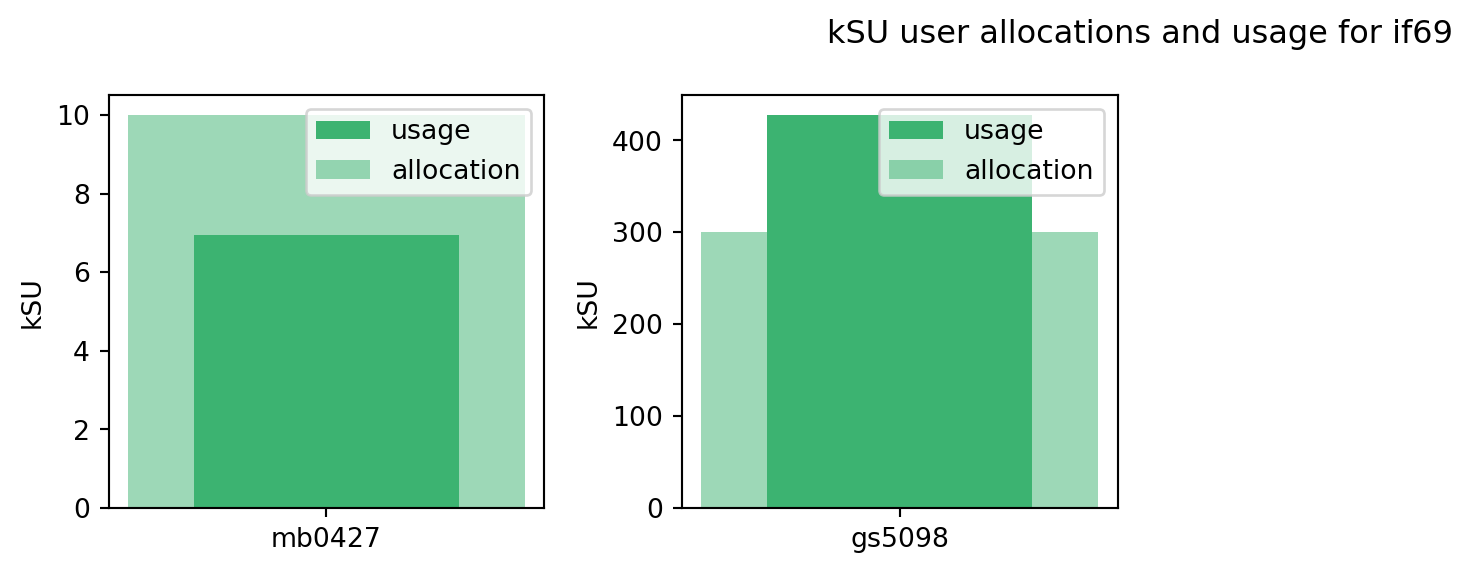

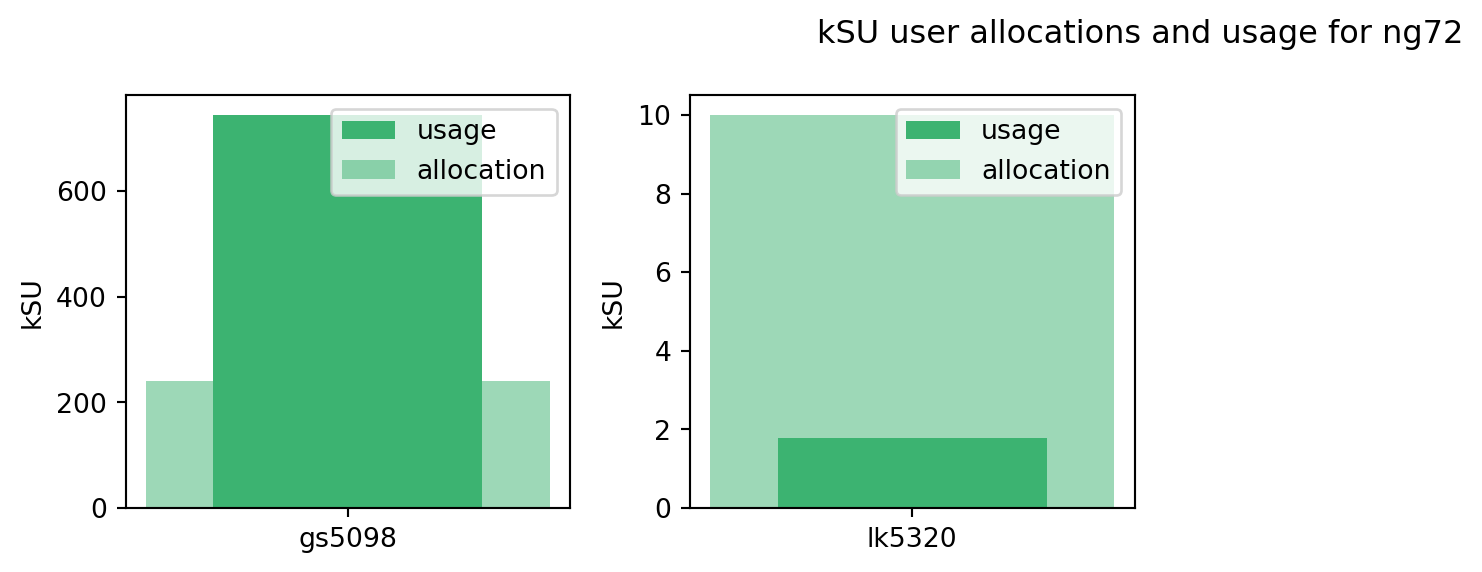

In [8]:
# Plot allocations for each user
for i,project in enumerate(grant_dict.keys()):
    num_columns=4  
    num_plots = len(alloc_df_dict[project].index)
    num_rows = int((num_plots-1)/num_columns+1)
    
    Position = range(1,num_plots+1)
    
    fig_height = num_rows*3
    fig_width = 12
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    k = 0
    
    for user in alloc_df_dict[project].index:
        ax = fig.add_subplot(num_rows, num_columns, Position[k])
        ax.bar(x=[user],height=alloc_df_dict[project]['usage'].loc[user],width=0.2,label='usage',color='mediumseagreen')
        ax.bar(x=[user],height=alloc_df_dict[project]['allocation'].loc[user],alpha=0.5,width=0.3,label='allocation',color='mediumseagreen')
        ax.yaxis.set_label_text('kSU')
        ax.legend()
    
        k += 1
        
    _ = plt.suptitle(f'kSU user allocations and usage for {project}')
    plt.tight_layout()

#### Column {width=60%}

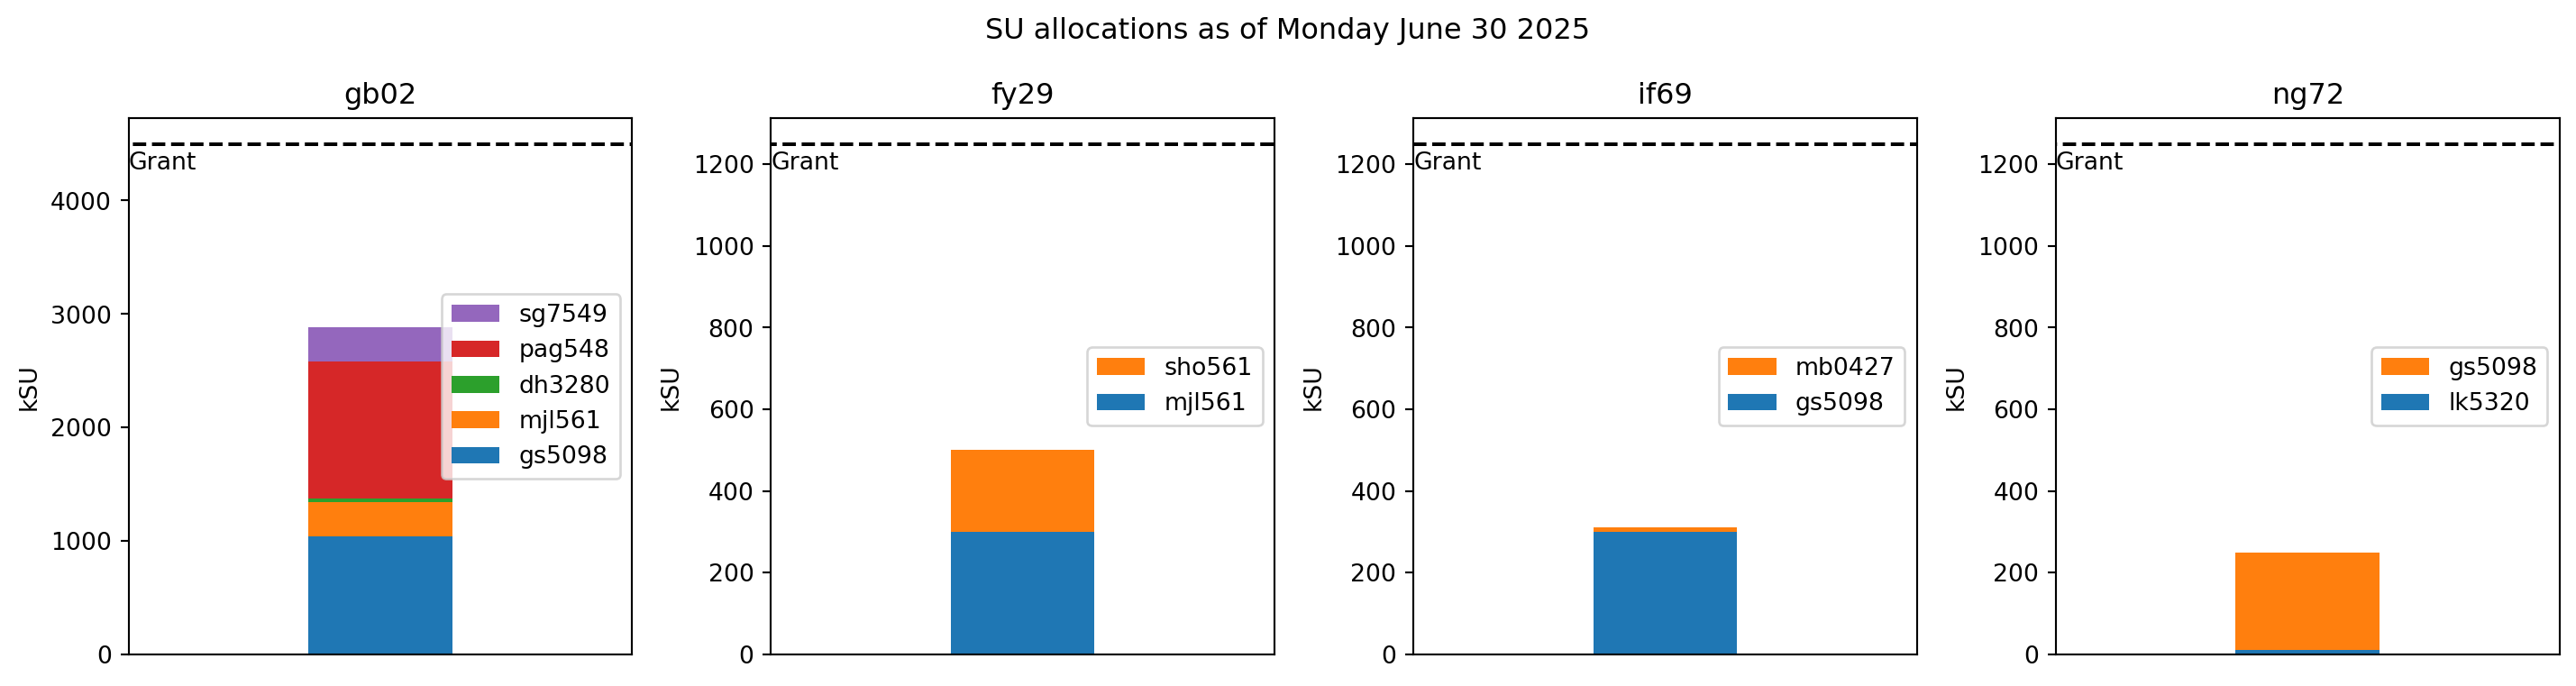

In [9]:
# Plot kSUs for every project
fig,axes = plt.subplots(1,len(grant_dict),figsize=(15,4))

USER_NAMES = 5  #Plot the top five usernames of SU usage

for i,project in enumerate(grant_dict.keys()):

    allocation_df.xs(project,level='project').T.plot.bar(stacked=True,ax=axes[i],width=0.2)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1],loc=7)
    axes[i].hlines(grant_dict[project],-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*grant_dict[project]))
    axes[i].yaxis.set_label_text('kSU')
    axes[i].xaxis.set_ticks([])
    axes[i].set_title(project)

_ = fig.suptitle(f"SU allocations as of {dt.datetime.today().strftime('%A %B %d %Y')}")
plt.tight_layout()

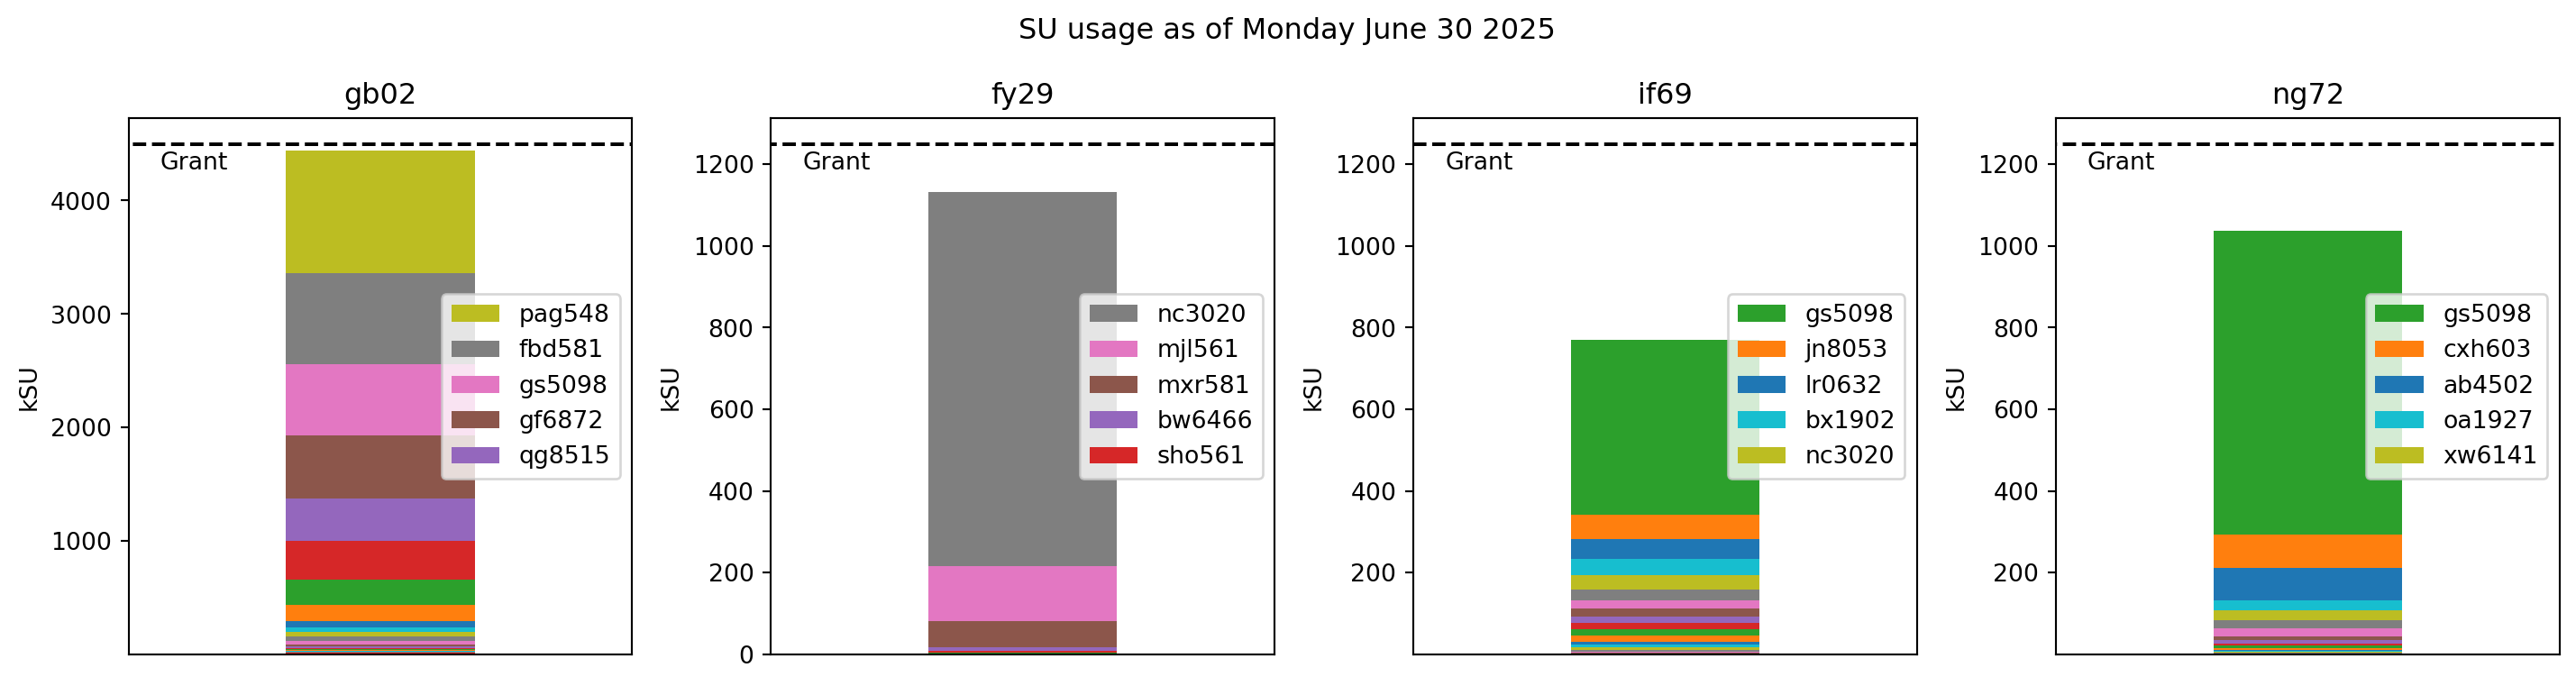

In [10]:
# Plot kSUs for every project
fig,axes = plt.subplots(1,len(grant_dict),figsize=(15,4))

USER_NAMES = 5  #Plot the top five usernames of SU usage

for i,project in enumerate(grant_dict.keys()):
    
    SU_df_dict[project]['usage'].sort_values(ascending=True).to_frame().T.plot.bar(stacked=True,ax=axes[i],width=0.3)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1],loc=7)
    axes[i].hlines(grant_dict[project],-5,5,linestyles='dashed',color='black')
    axes[i].annotate('Grant',(-0.35,0.95*grant_dict[project]))
    axes[i].yaxis.set_label_text('kSU')
    axes[i].xaxis.set_ticks([])
    axes[i].set_title(project)

_ = fig.suptitle(f"SU usage as of {dt.datetime.today().strftime('%A %B %d %Y')}")
plt.tight_layout()

In [11]:
storage_data = create_storage_df(storage_dict)

### Storage usage

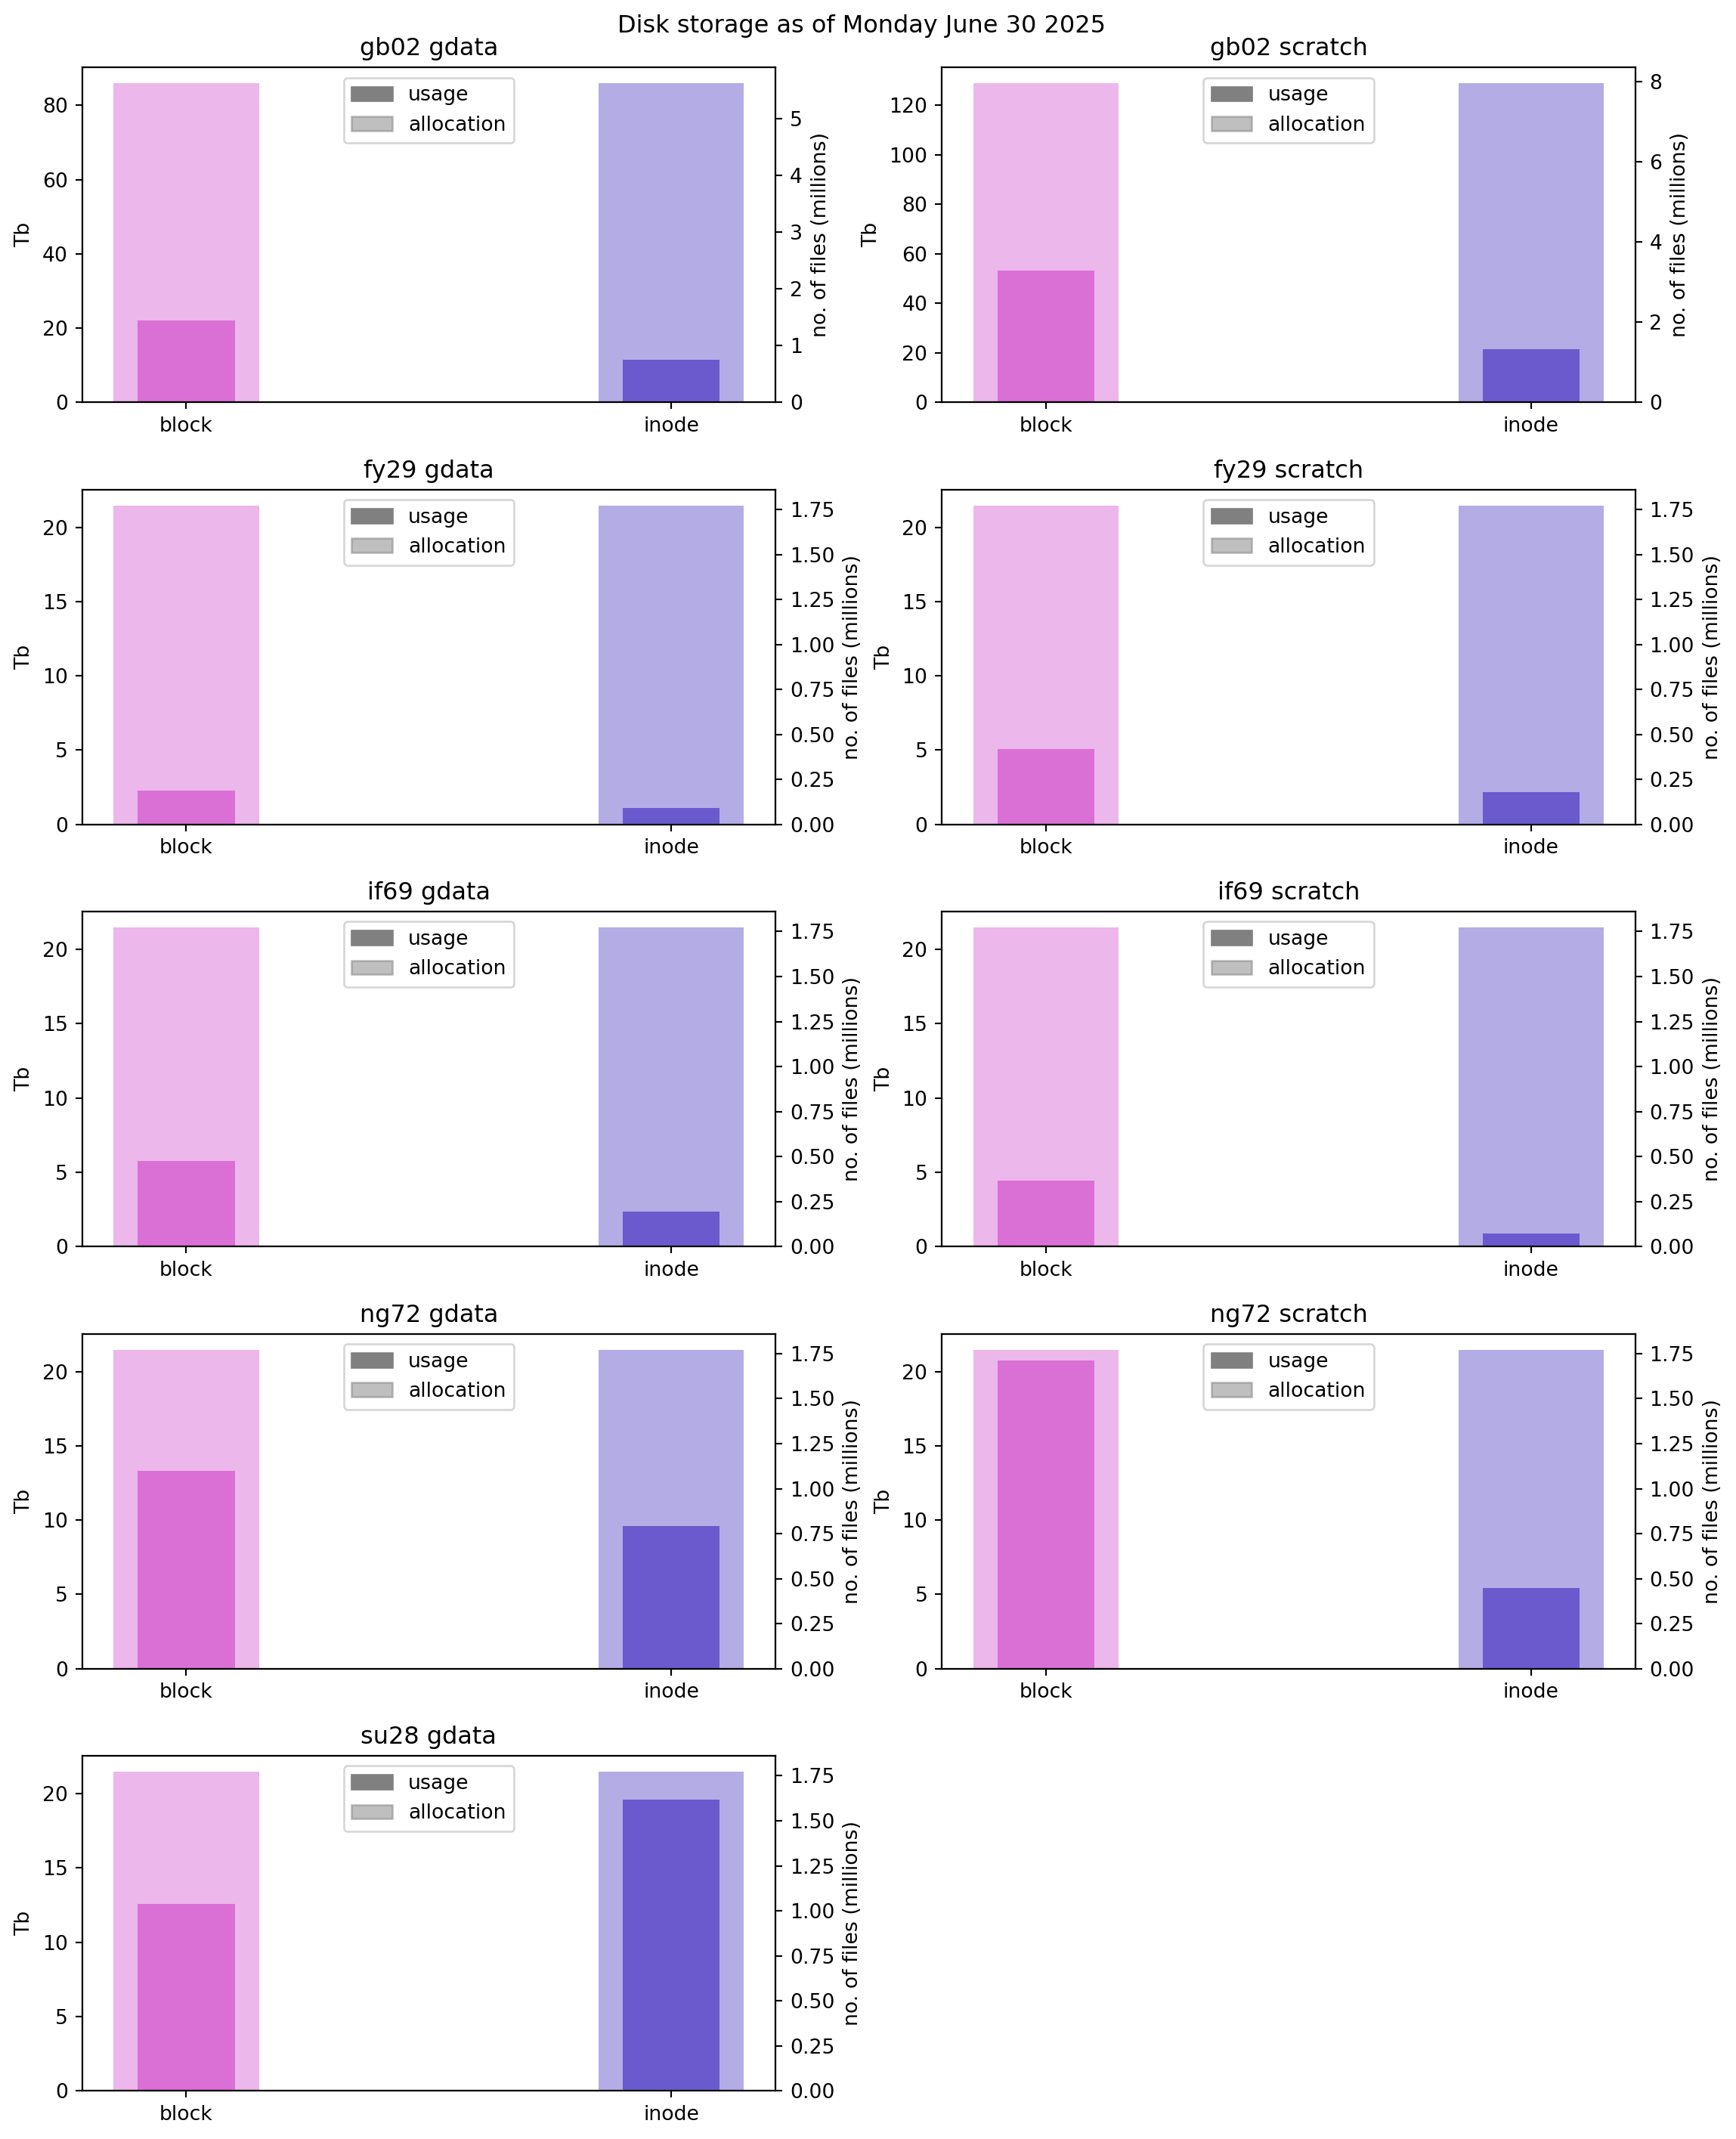

In [12]:
num_columns=2
num_rows = len(COE_PROJECTS)    
num_plots = sum(len(v) for v in storage_dict.values())
    
Position = range(1,num_plots+1)

fig_height = num_rows*3
fig_width = 12

fig = plt.figure(figsize=(fig_width,fig_height))
k = 0

for project in COE_PROJECTS:
    for disk in storage_data[project].keys():

        ax = fig.add_subplot(num_rows, num_columns, Position[k])
        ax.bar(x=['block'],height=storage_data[project][disk]['usage'].loc['block'],width=0.2,label='usage',color='orchid')
        ax.bar(x=['block'],height=storage_data[project][disk]['allocation'].loc['block'],alpha=0.5,width=0.3,label='allocation',color='orchid')
        ax2=ax.twinx()
        ax2.bar(x=['inode'],height=storage_data[project][disk]['usage'].loc['inode'],width=0.2,label='usage',color='slateblue')
        ax2.bar(x=['inode'],height=storage_data[project][disk]['allocation'].loc['inode'],alpha=0.5,width=0.3,color='slateblue',label='allocation')
        ax.yaxis.set_label_text('Tb')
        ax2.yaxis.set_label_text('no. of files (millions)')
        
        usage_patch=mpatches.Patch(color='grey',label='usage')
        alloc_patch=mpatches.Patch(color='grey',alpha=0.5,label='allocation')
        ax.legend(handles=[usage_patch,alloc_patch],loc=9)
        ax.set_title(f'{project} {disk}')

        k+= 1

_ = fig.suptitle(f"Disk storage as of {dt.datetime.today().strftime('%A %B %d %Y')}")
plt.tight_layout()

In [13]:
du_dict = find_largest_users(COE_PROJECTS)

In [14]:
user_storage_numeric=pd.concat(du_dict)['TOTAL SIZE']

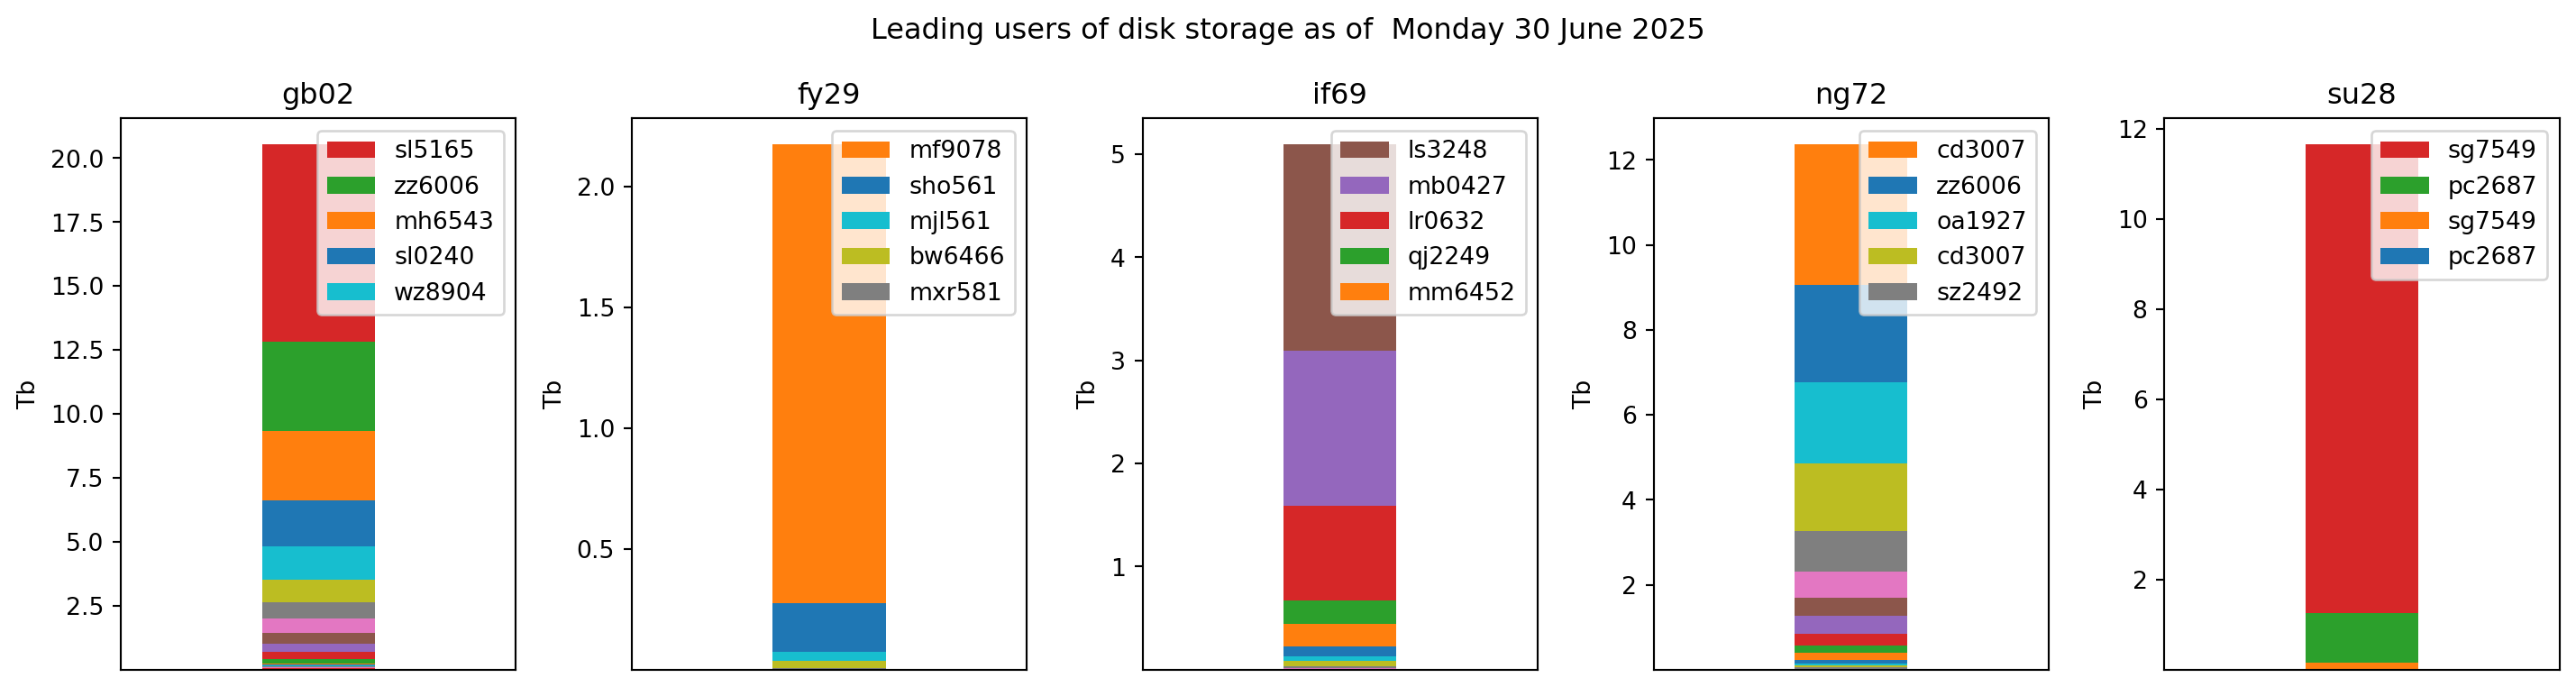

In [15]:
# Plot the five largest users for each project
fig,axes = plt.subplots(1,len(COE_PROJECTS),figsize=(15,4))

for i,project in enumerate(COE_PROJECTS):    
    (user_storage_numeric[project].to_frame().dropna().astype('int').sort_values('TOTAL SIZE')/1024**4).T.plot.bar(stacked=True,ax=axes[i],width=0.2)
    patches, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=patches[-USER_NAMES:][::-1],labels=labels[-USER_NAMES:][::-1])
    axes[i].yaxis.set_label_text('Tb')
    axes[i].get_xaxis().set_ticks([])
    axes[i].set_title(project)

_ = fig.suptitle(f"Leading users of disk storage as of  {dt.datetime.today().strftime('%A %d %B %Y')}")
plt.tight_layout()

# Projects

| NCI Project  | Theme                           | Centre Projectcs                                      | NCI Project Lead  | SU/quarter + storage     |
|--------------|---------------------------------|-------------------------------------------------------|-------------------|------------------------|
| [gb02](https://my.nci.org.au/mancini/project/gb02)| Centre-wide Strategic Projects  | All              | gb02 Panel*       | 9 MSUs + 80 TB Storage |
| [fy29](https://my.nci.org.au/mancini/project/fy29)| High-Resolution Modelling       | Modelling        | Bethan White      | 5 MSUs + 20TB Storage  |
| [if69](https://my.nci.org.au/mancini/project/if69)| Circulation Change              | Weather System Dynamics, Variability & Warmer World,  | Chenhui Jin       | 5 MSUs + 20TB Storage  |
| [ng72](https://my.nci.org.au/mancini/project/ng72)| Weather Change                  | Weather Resources & High Impact Weather               | Andrew Brown      | 5 MSUs + 20TB Storage  |
| [su28](https://my.nci.org.au/mancini/project/su28) | Datasets for the Centre         | All                                                   | Sam Green         | 20 TB Storage          |

*gb02 panel: Navid Constantinou, Paul Gregory, Bethan White, Chenhui Jin, Andrew Brown, and Sam Green


Last update: `{python} dt.datetime.now().strftime("%d-%m-%Y %H:%m")`